In [25]:
import sys
sys.path.append("../models")

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image



import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

from model_v2 import CNNModelV2

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [3]:
import json
import pandas as pd

with open("/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/results/metrics_v2.json", "r") as f:
    metrics = json.load(f)

# Extract values directly from the JSON
epochs = list(range(1, metrics["epochs"] + 1))
train_losses = metrics["train_loss"]
val_accuracies = metrics["val_accuracy"]

# Build DataFrame
df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": train_losses,
    "val_accuracy": val_accuracies
})

df


,epoch,train_loss,val_accuracy
0,1,0.663841,0.6880
1,2,0.581425,0.7374
2,3,0.538459,0.7512
3,4,0.499443,0.7932
4,5,0.459477,0.8172
5,6,0.441720,0.8028
6,7,0.421867,0.8168
7,8,0.405553,0.8118
8,9,0.393115,0.8144
9,10,0.384361,0.6806


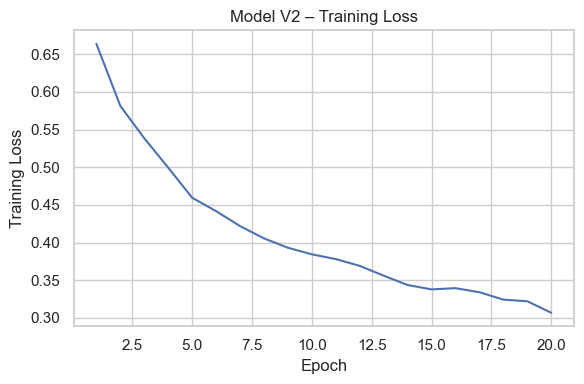

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
plt.plot(df["epoch"], df["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Model V2 – Training Loss")
plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig("../results/loss_curve_v2.png", dpi=300)

plt.show()


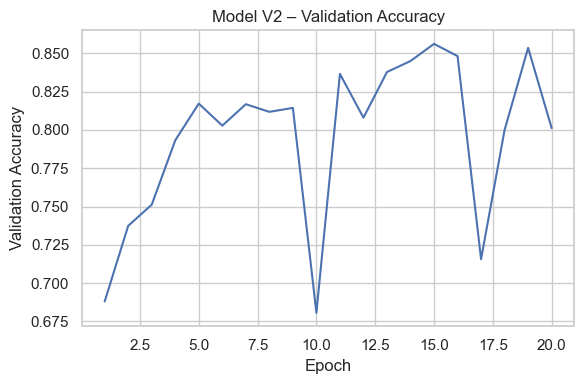

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(df["epoch"], df["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model V2 – Validation Accuracy")
plt.tight_layout()
plt.savefig("../results/accuracy_curve_v2.png", dpi=300)
plt.show()


In [14]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_path  # returning path instead of label

# transforms
testTransform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# dataset + loader
testData = TestImageDataset(
    "/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/test",
    transform=testTransform
)

testLoader = DataLoader(testData, batch_size=32, shuffle=False)

len(testData)


12500

In [15]:
model = CNNModelV2().to(device)

# Load model_v2 weights
state = torch.load("../models/model_v2.pth", map_location=device)

model.load_state_dict(state)
model.eval()

CNNModelV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [16]:
allPaths = []
allPreds = []

with torch.no_grad():
    for imgs, paths in testLoader:
        imgs = imgs.to(device)

        out = model(imgs)
        _, preds = torch.max(out, 1)

        allPaths.extend(paths)
        allPreds.extend(preds.cpu().numpy().tolist())


In [17]:
import pandas as pd

df_preds = pd.DataFrame({
    "image_path": allPaths,
    "predicted_class": allPreds
})

df_preds.to_csv("../results/test_predictions_v2.csv", index=False)
df_preds.head()


,image_path,predicted_class
0,/Users/prajjvalgovil/Downloads/resmet/collabor...,0
1,/Users/prajjvalgovil/Downloads/resmet/collabor...,0
2,/Users/prajjvalgovil/Downloads/resmet/collabor...,1
3,/Users/prajjvalgovil/Downloads/resmet/collabor...,1
4,/Users/prajjvalgovil/Downloads/resmet/collabor...,0


In [18]:
class_names = ["cat", "dog"]  # adjust as needed
df_preds["predicted_label"] = df_preds["predicted_class"].apply(lambda x: class_names[x])


In [22]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_folder = "/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/train"
train_folder  = "/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/all/train"
test_folder   = "/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/all/test"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

files = [f for f in os.listdir(source_folder)
         if f.lower().endswith((".jpg",".jpeg",".png"))]

# Extract class names (prefix before ".")
classes = sorted(list({f.split(".")[0] for f in files}))

print("Detected classes:", classes)

# Create class subfolders inside train & test
for cls in classes:
    os.makedirs(os.path.join(train_folder, cls), exist_ok=True)
    os.makedirs(os.path.join(test_folder, cls), exist_ok=True)

# Split files by class
for cls in classes:
    cls_files = [f for f in files if f.startswith(cls)]
    
    train_f, test_f = train_test_split(cls_files, test_size=0.2, random_state=42)
    
    # copy training files
    for f in train_f:
        shutil.copy(os.path.join(source_folder, f),
                    os.path.join(train_folder, cls, f))
    
    # copy testing files
    for f in test_f:
        shutil.copy(os.path.join(source_folder, f),
                    os.path.join(test_folder, cls, f))

print("Splitting complete!")


Detected classes: ['cat', 'dog']
Splitting complete!


In [24]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

trainData = datasets.ImageFolder("/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/all/train", transform=transform)
testData  = datasets.ImageFolder("/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/all/test", transform=transform)

trainLoader = DataLoader(trainData, batch_size=32, shuffle=True)
testLoader  = DataLoader(testData, batch_size=32, shuffle=False)

classes = trainData.classes
print("Classes:", classes)

Classes: ['cat', 'dog']


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModelV2().to(device)
model.load_state_dict(torch.load("/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/models/model_v2.pth", map_location=device))
model.eval()

print("Model Loaded Successfully!")


Model Loaded Successfully!


In [28]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

trainData = datasets.ImageFolder("/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/all/test", transform=transform)
testData  = datasets.ImageFolder("/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/data/all/train", transform=transform)

trainLoader = DataLoader(trainData, batch_size=32, shuffle=True)
testLoader  = DataLoader(testData, batch_size=32, shuffle=False)

classes = trainData.classes
print("Classes:", classes)


Classes: ['cat', 'dog']


In [29]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, x):
        self.model.zero_grad()
        output = self.model(x)
        class_idx = output.argmax(1).item()

        output[:, class_idx].backward()

        grads = self.gradients[0]
        acts = self.activations[0]

        weights = grads.mean(dim=(1,2))
        cam = (weights[:, None, None] * acts).sum(dim=0)

        cam = np.maximum(cam.cpu().numpy(), 0)
        cam /= cam.max() if cam.max() != 0 else 1

        return cam, class_idx


In [32]:
def save_gradcam(model, testData, device):
    cam_engine = GradCAM(model, model.conv3)
    os.makedirs("results/gradcam", exist_ok=True)

    for i in range(0,5):
        img, label = testData[i]
        img_tensor = img.unsqueeze(0).to(device)

        cam, pred = cam_engine.generate(img_tensor)

        img_np = img.permute(1,2,0).numpy()

        heatmap = plt.cm.jet(cam)[..., :3]
        heatmap = np.array(Image.fromarray((heatmap*255).astype(np.uint8)).resize((128,128))) / 255.0
        overlay = np.clip(0.5*img_np + 0.5*heatmap, 0, 1)

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(img_np); plt.axis("off")
        plt.title(f"Original\nTrue: {classes[label]}")

        plt.subplot(1,2,2)
        plt.imshow(overlay); plt.axis("off")
        plt.title(f"Grad-CAM\nPred: {classes[pred]}")

        plt.savefig(f"/Users/prajjvalgovil/Downloads/resmet/collaborative_cnn_team04/results/gradcam/prajjval/sample_{i}.png", dpi=300)
        plt.close()

    print("✔ All Grad-CAM saved!")


In [33]:
save_gradcam(model, testData, device)

✔ All Grad-CAM saved!


In [34]:
def evaluate_model(model, testLoader, classes, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for imgs, lbls in testLoader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            labels.extend(lbls.numpy())

    # Classification report
    print("\n===== CLASSIFICATION REPORT =====")
    print(classification_report(labels, preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Save confusion matrix
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/confusion_matrix_v2.png", dpi=300)
    plt.close()

    print("✔ Saved confusion matrix to results/confusion_matrix.png")

    return cm



===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

         cat       0.96      0.73      0.83     10000
         dog       0.78      0.97      0.87     10000

    accuracy                           0.85     20000
   macro avg       0.87      0.85      0.85     20000
weighted avg       0.87      0.85      0.85     20000



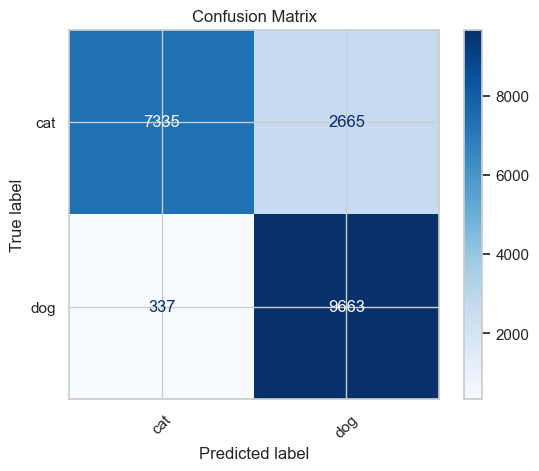

✔ Saved confusion matrix to results/confusion_matrix.png


In [35]:
cm = evaluate_model(model, testLoader, classes, device)